# Importing packages

In [111]:
import os
import io
import folium
import zipfile
import shapely
import openpyxl
import requests
import numpy as np 
import pandas as pd
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pandas_ods_reader import read_ods
from shapely.geometry.polygon import Polygon
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Define recursive functions

In [2]:
def download_from_url(file_url,filepath):
    req = requests.get(file_url)
    with open(filepath, 'wb') as file:
        file.write(req.content)
    
    
def download_zip_url(file_url,filedest):
    req = requests.get(file_url)
    zipped = zipfile.ZipFile(io.BytesIO(req.content))
    zipped.extractall(filedest)
    
def private_or_public_charging(private_devices,electric_cars):
     if private_devices >= electric_cars: 
        return 'Predomintantly private'
     else: 
        return 'Predomintantly public'

# Import files

In [3]:
dirname = 'Data'

In [4]:
if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(dirname):
        try:
            os.mkdir(dirname)
        except OSError:
            print ("Creation of the directory %s failed" % dirname)
        else:
            print ("Successfully created the directory %s " % dirname)
    else: 
        print ("Directory %s already exists" % dirname)

Directory Data already exists


## Downloading the required datasets for the analysis 

In [5]:
filename = 'postcodes.csv'

if os.path.isfile(dirname+'/'+filename):
    print ("File %s already exists" % filename)
else:
    download_zip_url('https://www.doogal.co.uk/files/postcodes.zip',dirname)
    print ("Successfully downloaded the file %s " % filename)

File postcodes.csv already exists


In [6]:
filename = 'osopenuprn_202011.csv'

if os.path.isfile(dirname+'/'+filename):
    print ("File %s already exists" % filename)
else:
    download_zip_url('https://api.os.uk/downloads/v1/products/OpenUPRN/downloads?area=GB&format=CSV&redirect',dirname)
    print ("Successfully downloaded the file %s " % filename)

File osopenuprn_202011.csv already exists


In [7]:
#Linking the required datasets with the URLs to download them from 

required_files = {'EIR_E0019012.xlsx':'https://storage.googleapis.com/na_evhs/EIR_E0019012.xlsx',
                 'electric-vehicle-charging-device-statistics-october-2020.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/933589/electric-vehicle-charging-device-statistics-october-2020.ods',
                 'veh0132.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942248/veh0132.ods',
                 'veh0134.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942250/veh0134.ods',
                 'veh0122.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942242/veh0122.ods',
                  'tra8901.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/925275/tra8901.ods'
                 }

In [8]:
# If not already present inside "Data" folder, download the required datasets and
# check the last time the datasets where downloaded/modified

for filename in required_files.keys():
    
    file_path = dirname+'/'+filename
    
    if os.path.isfile(file_path):
        print ("File %s already exists" % filename)
    else:
        download_from_url(required_files[filename],file_path)
        print ("Successfully downloaded the file %s " % filename)
    
    try:
        mtime = os.path.getmtime(file_path)
    except OSError:
        mtime = 0
    last_modified_date = datetime.fromtimestamp(mtime)
    
    print('    Last modified '+last_modified_date.strftime("%d/%m/%Y %H:%M:%S"))

File EIR_E0019012.xlsx already exists
    Last modified 12/01/2021 09:58:11
File electric-vehicle-charging-device-statistics-october-2020.ods already exists
    Last modified 12/01/2021 09:58:11
File veh0132.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0134.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0122.ods already exists
    Last modified 08/01/2021 10:50:22
File tra8901.ods already exists
    Last modified 15/01/2021 13:41:38


In [9]:
#For file containing multiple sheets (e.g. Excel spreadsheet files) determine the number and the name of each sheet

for filename in os.listdir(dirname):
    
    file_path = dirname+'/'+filename
    
    if filename.endswith('.ods') or filename.endswith('.xls'):
        
        file_preview = pd.ExcelFile(file_path, engine ='odf')
        sheets_number = [sheet for sheet in file_preview.sheet_names if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
        
    elif filename.endswith('.xlsx'):
        
        file_preview = openpyxl.load_workbook(file_path) 
        sheets_number = [sheet for sheet in file_preview.sheetnames if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
    
    

EIR_E0019012.xlsx has 1 sheet(s): ['bypostcodedistrict']
electric-vehicle-charging-device-statistics-october-2020.ods has 3 sheet(s): ['Info', 'EVCD_01', 'EVCD_02']
tra8901.ods has 1 sheet(s): ['TRA8901']
veh0122.ods has 11 sheet(s): ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
veh0132.ods has 4 sheet(s): ['VEH0132a', 'VEH0132b', 'VEH0132c', 'VEH0132d']
veh0134.ods has 3 sheet(s): ['VEH0134a', 'VEH0134b', 'VEH0134c']


# Import Postcode data

In [10]:
#Import file containing the information about, among others, postcodes, local authority, constituency and population
postcode = pd.read_csv(dirname+'/postcodes.csv') 

C:\Users\andre\.conda\envs\na2021\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
postcode.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area'],
      dtype='object')

In [12]:
postcode.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income,Sewage Company,Travel To Work Area
0,AB1 0AA,No,57.101474,-2.242851,385386.0,801193.0,NJ853011,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.31408,AB,AB1,Scotland,Scottish Water,9C9V4Q24+HV,NaN,NaN,Aberdeen
1,AB1 0AB,No,57.102554,-2.246308,385177.0,801314.0,NJ851013,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.55457,AB,AB1,Scotland,Scottish Water,9C9V4Q33+2F,NaN,NaN,Aberdeen
2,AB1 0AD,No,57.100556,-2.248342,385053.0,801092.0,NJ850010,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.54352,AB,AB1,Scotland,Scottish Water,9C9V4Q22+6M,NaN,NaN,Aberdeen
3,AB1 0AE,No,57.084444,-2.255708,384600.0,799300.0,NO845992,NaN,Aberdeenshire,North Kincardine,...,Portlethen,8.20809,AB,AB1,Scotland,Scottish Water,9C9V3PMV+QP,NaN,NaN,Aberdeen
4,AB1 0AF,No,57.096656,-2.258102,384460.0,800660.0,NJ844006,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.85583,AB,AB1,Scotland,Scottish Water,9C9V3PWR+MQ,NaN,NaN,Aberdeen


In [13]:
#Removing unnecessary columns to reduce the size and, therefore, the computational power required to process the dataframe
postcode = postcode.drop(['Grid Ref','County','Introduced', 'Terminated',
       'Parish', 'National Park','Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area'], axis = 1)

In [14]:
#Selecting only the postcodes that are still in use
postcode_sel = postcode.loc[postcode['In Use?']=='Yes']

In [15]:
postcode_sel.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code,Postcode area,Postcode district
2656,AB10 1AB,Yes,57.149606,-2.096916,394235.0,806529.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2658,AB10 1AF,Yes,57.148707,-2.097806,394181.0,806429.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2659,AB10 1AG,Yes,57.149051,-2.097004,394230.0,806467.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2660,AB10 1AH,Yes,57.148080,-2.094664,394371.0,806359.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2662,AB10 1AL,Yes,57.150058,-2.095916,394296.0,806579.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10


In [16]:
#Calculate the percentage of missing data in the dataframe

print('Missing {per:.2f}% of Postcode data'.format(per = postcode_sel['Postcode'].isnull().values.sum()/len(postcode_sel)*100)) 
print('Missing {per:.2f}% of District data'.format(per =postcode_sel['District'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Constituency data'.format(per =postcode_sel['Constituency'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Population data'.format(per =postcode_sel['Population'].isnull().values.sum()/len(postcode_sel)*100))

Missing 0.00% of Postcode data
Missing 0.08% of District data
Missing 0.08% of Constituency data
Missing 15.62% of Population data


In [17]:
#Replace NaN values in the population column with zeros
postcode_sel.loc[:,'Population'] = postcode_sel['Population'].fillna(0)

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [18]:
postcode_sel.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code,Postcode area,Postcode district
2656,AB10 1AB,Yes,57.149606,-2.096916,394235.0,806529.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10
2658,AB10 1AF,Yes,57.148707,-2.097806,394181.0,806429.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10
2659,AB10 1AG,Yes,57.149051,-2.097004,394230.0,806467.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10
2660,AB10 1AH,Yes,57.148080,-2.094664,394371.0,806359.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10
2662,AB10 1AL,Yes,57.150058,-2.095916,394296.0,806579.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10


In [19]:
postcode_district_list = postcode_sel['Postcode district'].unique().tolist()
postcode_district_number = len(postcode_sel['Postcode district'].unique())
postcode_area_list = postcode_sel['Postcode area'].unique().tolist()

In [20]:
unwanted_elements =['BF','GIR']
postcode_area_list = [area for area in postcode_area_list if area not in unwanted_elements]

In [21]:
subdirname = dirname+'/PD_borders'

if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(subdirname):
        try:
            os.mkdir(subdirname)
        except OSError:
            print ("Creation of the directory %s failed" % subdirname)
        else:
            print ("Successfully created the directory %s " % subdirname)
    else: 
        print ("Directory %s already exists" % subdirname)

Directory Data/PD_borders already exists


In [22]:
for item in postcode_area_list:

    filename = item+'.kml'
    file_path = subdirname+'/'+filename
    
    if os.path.isfile(file_path):
        print ("File %s already exists" % filename)
    else:
        download_from_url('https://www.doogal.co.uk/kml/'+filename,file_path)
        print ("Successfully downloaded the file %s " % filename)

File AB.kml already exists
File AL.kml already exists
File B.kml already exists
File BA.kml already exists
File BB.kml already exists
File BD.kml already exists
File BH.kml already exists
File BL.kml already exists
File BN.kml already exists
File BR.kml already exists
File BS.kml already exists
File BT.kml already exists
File CA.kml already exists
File CB.kml already exists
File CF.kml already exists
File CH.kml already exists
File CM.kml already exists
File CO.kml already exists
File CR.kml already exists
File CT.kml already exists
File CV.kml already exists
File CW.kml already exists
File DA.kml already exists
File DD.kml already exists
File DE.kml already exists
File DG.kml already exists
File DH.kml already exists
File DL.kml already exists
File DN.kml already exists
File DT.kml already exists
File DY.kml already exists
File E.kml already exists
File EC.kml already exists
File EH.kml already exists
File EN.kml already exists
File EX.kml already exists
File FK.kml already exists
Fil

In [23]:
#Calculate what is the percentage difference between the total UK population calculated using the data
#from the postcode_sel DataFrame and the actual value

population_sum = postcode_sel['Population'].sum()
uk_population = 66.65*10**6

print( 'Percentage difference in population {per:.2f} %'.format( per = abs(population_sum-uk_population)/uk_population*100 ))

Percentage difference in population 5.44 %


The realatively small difference between the values allows to categorise the missing information about the population as negligile overall. This, however, can still have a significant impact locally.\
 \
NOTE: The reason for this difference resides in the old nature of the postcode.csv file (released in 2019 and not uploaded ever since)

In [24]:
#Create a list containing the name of the Local Authority associated with the postcodes. 
#These should correspond to the local authority names in the 'electric-vehicle-charging-device-statistics-october-2020' file. 

district = postcode_sel['District'].unique().tolist()

In [25]:
#Remove any non string value from the district list
for item in district: 
    if not isinstance(item,str):
        district.remove(item)

In [26]:
#Create a list containing the code associated with each Local Authority. 
#These should correspond to the ones in the 'electric-vehicle-charging-device-statistics-october-2020' file. 

district_code = postcode_sel['District Code'].unique().tolist()

In [27]:
#Remove any non string value from the district list
for item in district_code: 
    if not isinstance(item,str):
        district_code.remove(item)

In [28]:
#Create a dictionary to associate each local Authority with the corresponding ONS code area
dic_la = {item:code for item,code in zip(district,district_code)}

In [29]:
dic_code = {code:item for code,item in zip(district_code,district)}

In [30]:
#Create a dictionary to associate each Local Authority with the corresponding postcodes

dic_district = {item:'' for item in district}
for item in district: 
    list_val = postcode_sel.loc[postcode_sel['District']==item]['Postcode'].values
    list_val_sel=[]
    for val in list_val:
        lval = val.split(' ')[0]
        if lval not in list_val_sel:
            list_val_sel.append(lval)
    dic_district[item] = list_val_sel

In [31]:
#Create a dictionary to associate each Local Authority with the corresponding population

dic_dist_population = {item:int(postcode_sel.loc[postcode_sel['District']==item]['Population'].sum()) for item in district}

# Import public charging devices data

## Charging devices per local authority

In [ ]:
dft_charging_devices_available_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_01', headers=False)
dft_charging_devices_available_import = dft_charging_devices_available_import[dft_charging_devices_available_import.iloc[:,1].notnull()]

dft_charging_devices_available = dft_charging_devices_available_import.iloc[1:]
dft_charging_devices_available.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_available.columns = dft_charging_devices_available_import.iloc[0]

In [ ]:
dft_charging_devices_available.head()

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = dft_charging_devices_available.isnull().values.sum()/len(dft_charging_devices_available)*100)) 

In [ ]:
dft_charging_devices_available = dft_charging_devices_available.dropna() #Removing rows containing NaN values 

In [ ]:
len(dft_charging_devices_available)

In [ ]:
#data_try = dft_charging_devices_available[dft_charging_devices_available['LA / Region Code'].isin(district_code)]

## Total charging devices per quarter since Q1 2015

In [ ]:
dft_charging_devices_quarter_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_02', headers=False) 
dft_charging_devices_quarter_import = dft_charging_devices_quarter_import[dft_charging_devices_quarter_import.iloc[:,1].notnull()]

dft_charging_devices_quarter = dft_charging_devices_quarter_import.iloc[1:]
dft_charging_devices_quarter.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_quarter.columns = dft_charging_devices_quarter_import.iloc[0]
dft_charging_devices_quarter = dft_charging_devices_quarter.fillna(method='ffill')
dft_charging_devices_quarter = dft_charging_devices_quarter.dropna(axis =1)
dft_charging_devices_quarter.head()

In [ ]:
dft_charging_devices_quarter.tail()

In [ ]:
df_charges_quarter = pd.DataFrame(dft_charging_devices_quarter['Total  Devices'])
df_charges_quarter['Time'] = [str(j)+' Q'+str(i)  for j in range(2015,2021) for i in range(1,5)][:-1]
df_charges_quarter =  df_charges_quarter.set_index('Time')

In [ ]:
## Plot the trend of the publicly available charging devices in the UK between Q1 2015 and Q3 2020 ##

plt.bar(df_charges_quarter.index,df_charges_quarter['Total  Devices'],.8)
plt.xticks(rotation = 90)
plt.ylabel('Number of Public Charge points')
plt.show()

# Import ULEVs data by postcode district

In [ ]:
#Import Ultra Low Emission Vehicles (ULEVs) table
dft_ulev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134a')
dft_ulev = dft_ulev_import[6:-14]
dft_ulev.columns = dft_ulev_import.iloc[5].values
dft_ulev.reset_index(inplace=True, drop=True)

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_ulev[dft_ulev['2020 Q3']=='c'])/len(dft_ulev)*100) )

In [ ]:
dft_ulev = dft_ulev.replace({'c':0}) # Replace the c values with zeros so that the statistics is not altered 

In [ ]:
#Import Battery Electric Vehicles (BEVs) table by postcode
dft_bev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134b')
dft_bev = dft_bev_import[6:-14]
dft_bev.columns = dft_bev_import.iloc[5].values
dft_bev.reset_index(inplace=True, drop=True)

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_bev[dft_bev['2020 Q3']=='c'])/len(dft_bev)*100))

In [ ]:
dft_bev = dft_bev.replace({'c':0})

In [ ]:
dft_bev.head()

In [ ]:
dft_bev_nhb = dft_bev.set_index('Postcode District 2')

In [ ]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs uptake

nhb_val = 'AB10'
nhb_sel = dft_bev_nhb.loc[nhb_val].reindex(index=dft_bev_nhb.loc[nhb_val].index[::-1])
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+nhb_val)
plt.show() 

In [ ]:
#Import Plug-in Hybrid Electric Vehicles (PHEVs) data
dft_phev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134c')
dft_phev = dft_phev_import[6:-14]
dft_phev.columns = dft_phev_import.iloc[5].values
dft_phev.reset_index(inplace=True, drop=True)

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_phev[dft_phev['2020 Q3']=='c'])/len(dft_phev)*100))

In [ ]:
dft_phev = dft_phev.replace({'c':0})

# Import ULEVs data by local authority

In [132]:
#Import Battery Electric Vehicles (BEVs) table by LA
dft_bev_la_import = read_ods(dirname+'/veh0132.ods', 'VEH0132b')
dft_bev_la = dft_bev_la_import[6:-14]
dft_bev_la.columns = dft_bev_la_import.iloc[5].values
dft_bev_la.reset_index(inplace=True, drop=True)

In [133]:
dft_bev_la_sel = dft_bev_la[dft_bev_la['ONS LA Code'].isin(district_code)]
dft_bev_la_sel = dft_bev_la_sel.drop(['Region/Local Authority'],axis = 1).set_index(['ONS LA Code'])
dft_bev_la_sel = dft_bev_la_sel.replace({'c':0})

In [134]:
print('Missing {per:.2f}% of entire data'.format(per = 100-(len(dft_bev_la_sel))/len(district_code)*100))

Missing 2.11% of entire data


In [ ]:
##Plot the Local Authority level of BEVs uptake

la_val = 'Cambridge'
la_sel = dft_bev_la_sel.loc[dic_la[la_val]].reindex(index=dft_bev_la_sel.loc[dic_la[la_val]].index[::-1])
plt.bar(la_sel.index,la_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+la_val)
plt.show() 

In [ ]:
dft_bev_all = pd.DataFrame(dft_bev_la.iloc[0][2:])
dft_bev_all = dft_bev_all.reindex(index=dft_bev_all.index[::-1]) # Sort the index (Time) in ascending order 
dft_bev_all.index.names =['Time']
dft_bev_all.columns =['Total BEVs']

In [ ]:
##Plot the National level of BEVs uptake

df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

x = np.arange(len(df_charges_bev.index))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x - width/2, df_charges_bev['Total  Devices'], width, label='Devices')
rects2 = ax.bar(x + width/2, df_charges_bev['Total BEVs'], width, label='BEVs')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total number')
ax.set_title('BEVs VS Devices Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)
ax.legend()

fig.tight_layout()

plt.show()
#fig.savefig('Devices_BEVs_comparision.png', bbox_inches='tight', dpi = 300)

# Import ALL vehicles data by postcode district

In [ ]:
sheet_index = sorted(['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011'])

In [ ]:
df = []

for idx in sheet_index:
    dft_all_import = read_ods(dirname+'/veh0122.ods', idx)
    dft_all_import = dft_all_import[dft_all_import.iloc[:,1].notnull()]
    dft_all = dft_all_import[2:]
    dft_all.columns = dft_all_import.iloc[1].values
    dft_all = dft_all.set_index('Postcode District')
    dft_all_sel = dft_all['Cars']
    dft_all_sel.columns = [idx +' Q'+str(i+1) for i in range(len(dft_all_sel.columns))]
    df.append(dft_all_sel)

In [ ]:
dft_all_merged = pd.concat(df, axis =1,join='inner')
dft_all_merged = dft_all_merged.iloc[:,3:]

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_all_merged[dft_all_merged['2020 Q3']=='c'])/len(dft_all_merged)*100))

In [ ]:
dft_all_merged =dft_all_merged.replace({'c':0})

In [ ]:
df_intersect =[]
for item in dft_all_merged.index: 
    if item in dft_bev_nhb.index.tolist():
        df_intersect.append(item)

In [ ]:
print('Missing {per:.2f}% of the entire postcode districts'.format(per = (1 -len(df_intersect)/postcode_district_number)*100))

In [ ]:
dft_bev_nhb_sel = dft_bev_nhb[dft_bev_nhb.index.isin(df_intersect)]
dft_all_merged_sel = dft_all_merged[dft_all_merged.index.isin(df_intersect)]

In [ ]:
dft_ratio = dft_bev_nhb_sel/dft_all_merged_sel*100

In [ ]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs proportion to total car fleet

nhb_val = 'CB3'
nhb_sel = dft_ratio.loc[nhb_val]
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('% of BEVs of total car fleet')
plt.title('BEVs percentage of total car fleet in '+nhb_val)
plt.show() 

# Import private chargers data

In [ ]:
fund_df_import = pd.read_excel(dirname+"/EIR_E0019012.xlsx")
fund_df_import = fund_df_import[fund_df_import.iloc[:,2].notnull()].dropna(axis =1)

fund_df = fund_df_import[1:]
fund_df.columns = fund_df_import.iloc[0].values
fund_df =fund_df.set_index('Postcode District')
fund_df.head()

In [ ]:
# As stated in the file, all postcode districts with counts of at least one but fewer than ten have are indicated as "…".
#For statistical purpose, a lower estimate of this value is 1 and therefore "…" is replaced by the value 1. 
fund_df = fund_df.replace({'…':1})

# Create a DataFrame containing the necessary information per Local Authority



In [ ]:
columns_name = ['Local Authority','Total electric vehicles (BEVs)','Total public charging devices','Total public charging devices per 100,000 population','Total private charging devices','Charging devices usage']
summary_dataframe = pd.DataFrame({item:[] for item in columns_name})

for area in district:
    total_electric_vehicles = dft_bev_la[dft_bev_la['ONS LA Code']==dic_la[area]]['2020 Q3'].mean()
    public_charging_devices,public_charging_devices_density = dft_charging_devices_available[dft_charging_devices_available['LA / Region Code']==dic_la[area]][['Total public\ncharging devices','Charging devices per\n100,000 population']].mean()
    evhs_grant,drs_grant = fund_df[fund_df.index.isin(dic_district[district[0]])][['EVHS Grants','DRS Grants']].sum()
    
    
    total_public_charging_devices = int(public_charging_devices) 
    total_public_charging_devices_density = public_charging_devices_density
    total_private_charging_devices = int(evhs_grant + drs_grant)
    charging_devices_usage = private_or_public_charging(total_private_charging_devices, total_electric_vehicles)
    
    summary_dataframe = summary_dataframe.append(pd.DataFrame([[area,total_electric_vehicles,total_public_charging_devices,total_public_charging_devices_density,total_private_charging_devices,charging_devices_usage]], columns = columns_name))
    
summary_dataframe = summary_dataframe.set_index('Local Authority') # Set the Local Authority name as the DataFrame index

# Print the lookup table for each Local Authority

In [ ]:
##Lookup table for each local authority number of EVs, public and private charging devices 
la_code = 'E06000047'

print('Summary for the '+dic_code[la_code]+' Local Authority:\n')
print(summary_dataframe.loc[la_name])

# Identify Local Authorities where the commercial fleet is statistically significant

In [ ]:
#Subselect for the dataframe the local authorities where there are more EVs than private chargers 
ratios = summary_dataframe['Total electric vehicles (BEVs)']/summary_dataframe['Total private charging devices']
old_ratios = len(ratios)

In [ ]:
#Import ULEVs keepership table by LA
dft_keep_import = read_ods(dirname+'/veh0132.ods', 'VEH0132d')
dft_keep_import = dft_keep_import[dft_keep_import.iloc[:,1].notnull()]

dft_keep = dft_keep_import[1:]
dft_keep.columns = dft_keep_import.iloc[0]
dft_keep.reset_index(inplace=True, drop=True)
dft_keep.head()

In [ ]:
dft_keep_sel = dft_keep[dft_keep['ONS LA Code'].isin(district_code)]

In [ ]:
#Select LAs for which the number of company ULEVs is twice the number of private ULEVs

outliers_code = dft_keep_sel[dft_keep_sel['Company'] > 2 *dft_keep_sel['Private']]['ONS LA Code'].tolist()
outliers_la = [dic_code[item] for item in outliers]

In [ ]:
#Remove the previously identified LAs from the selected list rsel

ratios =ratios[~ratios.index.isin(outliers_la)]

print('{val} local authorities were removed from the list ({per:.2f}% of the data)'.format(val = old_ratios-len(ratios), per = (1-len(ratios)/old_ratios)*100 ))

ratios_sel=ratios_sel[ratios_sel!=np.inf]

print('{per:.2f}% of the data is infinity'.format(per = (1 -len(ratios_sel)/len(ratios))*100))

ratios_sel=ratios_sel.dropna()

print('{per:.2f}% of the data is NaN'.format(per = (1 - len(ratios_sel)/len(ratios))*100))
old_rsel = len(ratios_sel)

# Investigate top and bottom 10 Local authorities for public charger usage

In [ ]:
ratios_gt_one = ratios_sel[ratios_sel >1]

print('{per:.2f}% of the local authorities have more BEVs than private chargers'.format(per = len(ratios_gt_one)/len(ratios)*100))

In [ ]:
#Mean and median values for the BEVs/Private chargers > 1, respectively 
print(ratios_gt_one.mean())
print(ratios_gt_one.median())

In [ ]:
#Standard Deviation values for the BEVs/Private chargers > 1
print(ratios_gt_one.std())

In [ ]:
x = np.arange(len(ratios_gt_one))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x, ratios_gt_one, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/Private chargers')
ax.set_title('BEVs/Private chargers ratio > 1')
ax.set_xticks(x)
ax.set_xlim(0,len(ratios_gt_one))
ax.set_xticklabels(ratios_gt_one.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
#Top 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values(ascending = False).head(10)

In [ ]:
#Bottom 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values().head(10)

# Variation in BEVs uptake within a select few LAs

In [ ]:
ratios_sel.sort_values(ascending=False).head(15)

In [ ]:
ratios_sel.sort_values(ascending=False)[170:180]

In [ ]:
ratios_sel.sort_values(ascending=False).tail(15)

In [ ]:
la_selection = ['Sheffield','East Cambridgeshire','Richmondshire']
df_selection =[]

for area in la_selection:
    df_selection.append(dft_bev_la_sel.loc[dic_la[area]].reindex(index=dft_bev_la_sel.loc[dic_la[area]].index[::-1]))

x = np.arange(len(df_selection[0].index))
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x -width, df_selection[2], width, label=la_selection[2])
rects2 = ax.bar(x, df_selection[1], width, label=la_selection[1])
rects3 = ax.bar(x + width,  df_selection[0], width, label=la_selection[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total BEVs number')
ax.set_title('BEVs Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_selection[0].index, rotation = 90)
ax.legend()
ax.autoscale(tight=True)

fig.tight_layout()

plt.show()

# Import vehicle annual mileage by local authority

In [119]:
dft_vehicle_miles_import = read_ods(dirname+'/tra8901.ods', 'TRA8901', headers=False)
dft_vehicle_miles_import = dft_vehicle_miles_import[dft_vehicle_miles_import.iloc[:,4].notnull()]

dft_vehicle_miles = dft_vehicle_miles_import.iloc[1:]
dft_vehicle_miles.columns = dft_vehicle_miles_import.iloc[0]
dft_vehicle_miles = dft_vehicle_miles.dropna(axis=1)

dft_vehicle_miles = dft_vehicle_miles[dft_vehicle_miles['LA Code'].isin(district_code)]
dft_vehicle_miles.reset_index(inplace=True, drop=True) #reset the index
dft_vehicle_miles.insert(loc=1, column='Local Authority', value=[dic_code[item] for item in dft_vehicle_miles['LA Code']])
dft_vehicle_miles = dft_vehicle_miles.set_index('LA Code')

In [143]:
print('Missing {per:.2f}% of entire local authorities'.format(per = len(dft_vehicle_miles)/len(district_code)*100))

Missing 47.23% of entire local authorities


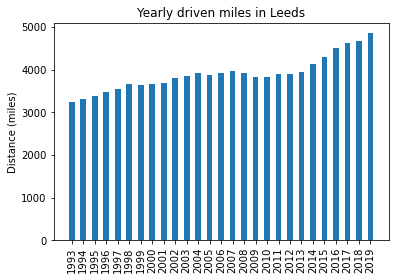

In [142]:
##Plot the Local Authority level of yearly miles driven

la_val = 'Leeds'
la_sel = dft_vehicle_miles.loc[dic_la[la_val]][1:]
la_sel.index = [str(i) for i in range(1993,2020)]
plt.bar(la_sel.index,la_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Distance (miles)')
plt.title('Yearly driven miles in '+la_val)
plt.show() 

# Interactive plots (WORK IN PROGRESS)

In [ ]:
la_geo = 'Data/LA_borders/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'

In [ ]:
data_try.columns

In [ ]:
import json
communities_geo = la_geo

# open the json file - json.load() methods returns a python dictionary
with open(communities_geo) as communities_file:
    communities_json = json.load(communities_file)
    
# we loop through the dictionary to obtain the name of the communities in the json file
denominations_json = []
for index in range(len(communities_json['features'])):
    denominations_json.append(communities_json['features'][index]['properties']['LAD20CD'])


In [ ]:
communities_json['features'][index]['properties']

In [ ]:
data_try.columns

In [ ]:
for item in denominations_json:
    if not item in data_try['LA / Region Code'].tolist():
        print(item)

In [ ]:
sorted(data_try['LA / Region Code'].tolist())==denominations_json

In [ ]:
# file name - file is located in the working directory
communities_geo = la_geo # geojson file

#  tiles = "cartodbpositron"
#communities_map = folium.Map(location=[40.416775, -3.703790], zoom_start=6, tiles='stamenwatercolor')
communities_map = folium.Map(location=[54.7, -4.6],
                    tiles = "cartodbpositron",
                    zoom_start = 5.4) 

In [ ]:
# choropleth = folium.Choropleth(
#     name = 'charging_dev',
#     geo_data=communities_geo,
#     data=data_try,
#     columns=['LA / Region Code', 'Total public\ncharging devices', 'Charging devices per\n100,000 population'],
#     key_on='feature.properties.LAD20CD',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Total public charging devices',
#     smooth_factor=0).add_to(communities_map)

# style_function = "font-size: 15px; font-weight: bold"
# choropleth.geojson.add_child(
#     folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))

# folium.LayerControl().add_to(communities_map)

In [ ]:
choropleth = folium.Choropleth(
    name = 'charging_dev',
    geo_data=communities_geo,
    data=data_try,
    columns=['LA / Region Code', 'Total public\ncharging devices', 'Charging devices per\n100,000 population'],
    key_on='feature.properties.LAD20CD',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Total public charging devices',
    smooth_factor=0).add_to(communities_map)
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))

choropleth = folium.Choropleth(
    name = 'charging_dens',
    geo_data=communities_geo,
    data=data_try,
    columns=['LA / Region Code', 'Charging devices per\n100,000 population'],
    key_on='feature.properties.LAD20CD',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Total charging devices per 100,000 population',
    smooth_factor=0).add_to(communities_map)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))
folium.LayerControl().add_to(communities_map)

# UPRNs

In [112]:
#Import the csv file listing all the UPRNs per postcode district 

df_uprn = pd.read_csv(dirname+'/UPRNs.csv', index_col=0)
df_uprn.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
Postcode District,,,,,
AB10,9051044244,392793.00,805619.00,57.141395,-2.120729
AB10,9051058739,393058.00,804612.00,57.132354,-2.116322
AB10,9051058738,393059.00,804620.00,57.132425,-2.116306
AB10,9051058737,393063.00,804631.00,57.132524,-2.116240
AB10,9051058736,393061.86,804640.43,57.132609,-2.116259


In [93]:
#Import the files containing the coordinates for each postcode district and combine them in a single dataframe 

for item in postcode_area_list:
    
    if item=='AB':
        filename = item+'.kml'
        file_path = subdirname+'/'+filename

        df_bound = gpd.read_file(file_path, driver='KML')
    else:
        filename = item+'.kml'
        file_path = subdirname+'/'+filename

        polys = gpd.read_file(file_path, driver='KML')
        df_bound = df_bound.append(polys, ignore_index=True)

        
df_postcode_district = df_bound[df_bound['Name'].isin(postcode_district_list)].set_index('Name')
df_postcode_district.index.name = 'Postcode District'
df_postcode_district = df_postcode_district.sort_index()

In [94]:
df_postcode_district.head()

,Description,geometry
Postcode District,,
AB10,"AB10 postcode district<br xmlns=""""></br><a hre...","MULTIPOLYGON (((-2.09560 57.11318, -2.09400 57..."
AB11,"AB11 postcode district<br xmlns=""""></br><a hre...","MULTIPOLYGON (((-2.05193 57.17075, -2.02345 57..."
AB12,"AB12 postcode district<br xmlns=""""></br><a hre...","MULTIPOLYGON (((-2.09608 57.14849, -2.09552 57..."
AB13,"AB13 postcode district<br xmlns=""""></br><a hre...","MULTIPOLYGON (((-2.28903 57.14867, -2.28762 57..."
AB14,"AB14 postcode district<br xmlns=""""></br><a hre...","MULTIPOLYGON (((-2.30175 57.08001, -2.28894 57..."


## Map and total number of UPRNs per Postcode District 

In [116]:
postcode_value = 'CB1'
postcode_selection = df_uprn.loc[postcode_value]
locations = postcode_selection[['LATITUDE', 'LONGITUDE']]
locationlist = locations.values.tolist()

print('In {} there are {} UPRNs'.format(postcode_value,df_uprn.loc[postcode_value]['UPRN'].count()))

In CB1 there are 30731 UPRNs


In [109]:
m = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(df_postcode_district.loc[postcode_value:postcode_value]).add_to(m)
for point in range(len(locationlist)):
     folium.Marker(locationlist[point], popup=postcode_selection['UPRN'][point]).add_to(m)
m.save(postcode_value+".html")

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
